In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import collections

import pandas as pd

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from transformers import DebertaTokenizer, TFDebertaModel  # to get text embedding
from transformers import ViTFeatureExtractor, TFViTModel  # to get image embedding

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# https://keras.io/examples/vision/nl_image_search/
# https://keras.io/examples/vision/image_classification_with_vision_transformer/  # ViT architecture
# the task is similar to CLIP

2022-11-23 18:29:15.917176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 18:29:15.918262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 18:29:15.918944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 18:29:15.920848: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed()

Random seed set as 42


In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = DebertaTokenizer.from_pretrained("kamalkraj/deberta-base")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

#### Extract inputs and targets to defaultdict

In [4]:
image_paths_to_captions = collections.defaultdict(list)
image_dir = "../input/flickr30k/images/"

with open("../input/flickr30k/captions.txt", "r") as infile:
    annotations = infile.readlines()[1:]
    
for element in annotations:
    caption = element.split("|")[-1].lower().rstrip(" .\n")
    image_path = image_dir + element.split("|")[0]
    image_paths_to_captions[image_path].append(caption)

image_paths = list(image_paths_to_captions.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 31783


In [5]:
image_dir = "../input/flickr30k/images/"

with open("../input/flickr30k/captions.txt", "r") as infile:
    annotations = infile.readlines()[1:]

paths, captions = [], []
for element in annotations:
    caption = element.split("|")[-1].lower().rstrip(" .\n")
    image_path = image_dir + element.split("|")[0]
    paths.append(image_path)
    captions.append(caption)

print(f"Number of images: {len(paths)}")

Number of images: 158915


In [6]:
df = pd.DataFrame(data={"path": paths, "caption": captions}).sample(60000, random_state=42).reset_index(drop=True)  # 50000 initially
df.head()

,path,caption
0,../input/flickr30k/images/5797756884.jpg,a man is sitting on an upturned white bucket p...
1,../input/flickr30k/images/109260218.jpg,spelunkers pose inside a rock cavern while bat...
2,../input/flickr30k/images/5087543347.jpg,a toddler enjoying her birthday cake
3,../input/flickr30k/images/450596617.jpg,two people are walking by the ocean
4,../input/flickr30k/images/226481576.jpg,"young , smiling , blond female police officer ..."


In [7]:
train, valid = train_test_split(df, test_size=8000, shuffle=True, random_state=42)
valid, test = train_test_split(valid, test_size=2000, random_state=42)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [8]:
def tokenize_text(sentences, max_length=512, padding='max_length'):
    return tokenizer(                                           
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

def image_extractor(image):  # + resize 224x224
    return feature_extractor(image, return_tensors="tf")

def train_generator():
    for i in range(train.shape[0]):
        image = Image.open(train.iloc[i, 0])
        text = tokenize_text(train.iloc[i, 1])
        input_ids = text["input_ids"]
        attention_mask = text["attention_mask"]
        yield image_extractor(image)["pixel_values"][0], input_ids[0], attention_mask[0]
        
def valid_generator():
    for i in range(valid.shape[0]):
        image = Image.open(valid.iloc[i, 0])
        text = tokenize_text(valid.iloc[i, 1])
        input_ids = text["input_ids"]
        attention_mask = text["attention_mask"]
        yield image_extractor(image)["pixel_values"][0], input_ids[0], attention_mask[0]

In [9]:
batch_size = 32

output_signature = (tf.TensorSpec(shape=(3, 224, 224), dtype=tf.float32),  # pytorch-like tensor
                    tf.TensorSpec(shape=(512,), dtype=tf.int32),
                    tf.TensorSpec(shape=(512,), dtype=tf.int32))

train_ds = tf.data.Dataset.from_generator(train_generator, output_signature=output_signature) \
                                          .shuffle(10 * batch_size) \
                                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                                          .batch(batch_size)

valid_ds = tf.data.Dataset.from_generator(valid_generator, output_signature=output_signature) \
                                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                                          .batch(batch_size)

#### Define Text, Image Encoders and final model

In [10]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [11]:
def create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1, trainable=False
):
    base = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    for layer in base.layers:
        layer.trainable = trainable

    inputs = layers.Input(shape=(3, 224, 224), name="image_input")
    
    embeddings = base([inputs]).last_hidden_state[:, 1:, :]  # [bs, 196, 768], except CLS token
    embeddings = layers.GlobalAveragePooling1D(data_format="channels_last")(embeddings)  # [bs, 768]

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    return keras.Model(inputs, outputs, name="vision_encoder")

In [12]:
vit = create_vision_encoder()

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

2022-11-23 18:30:12.876362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


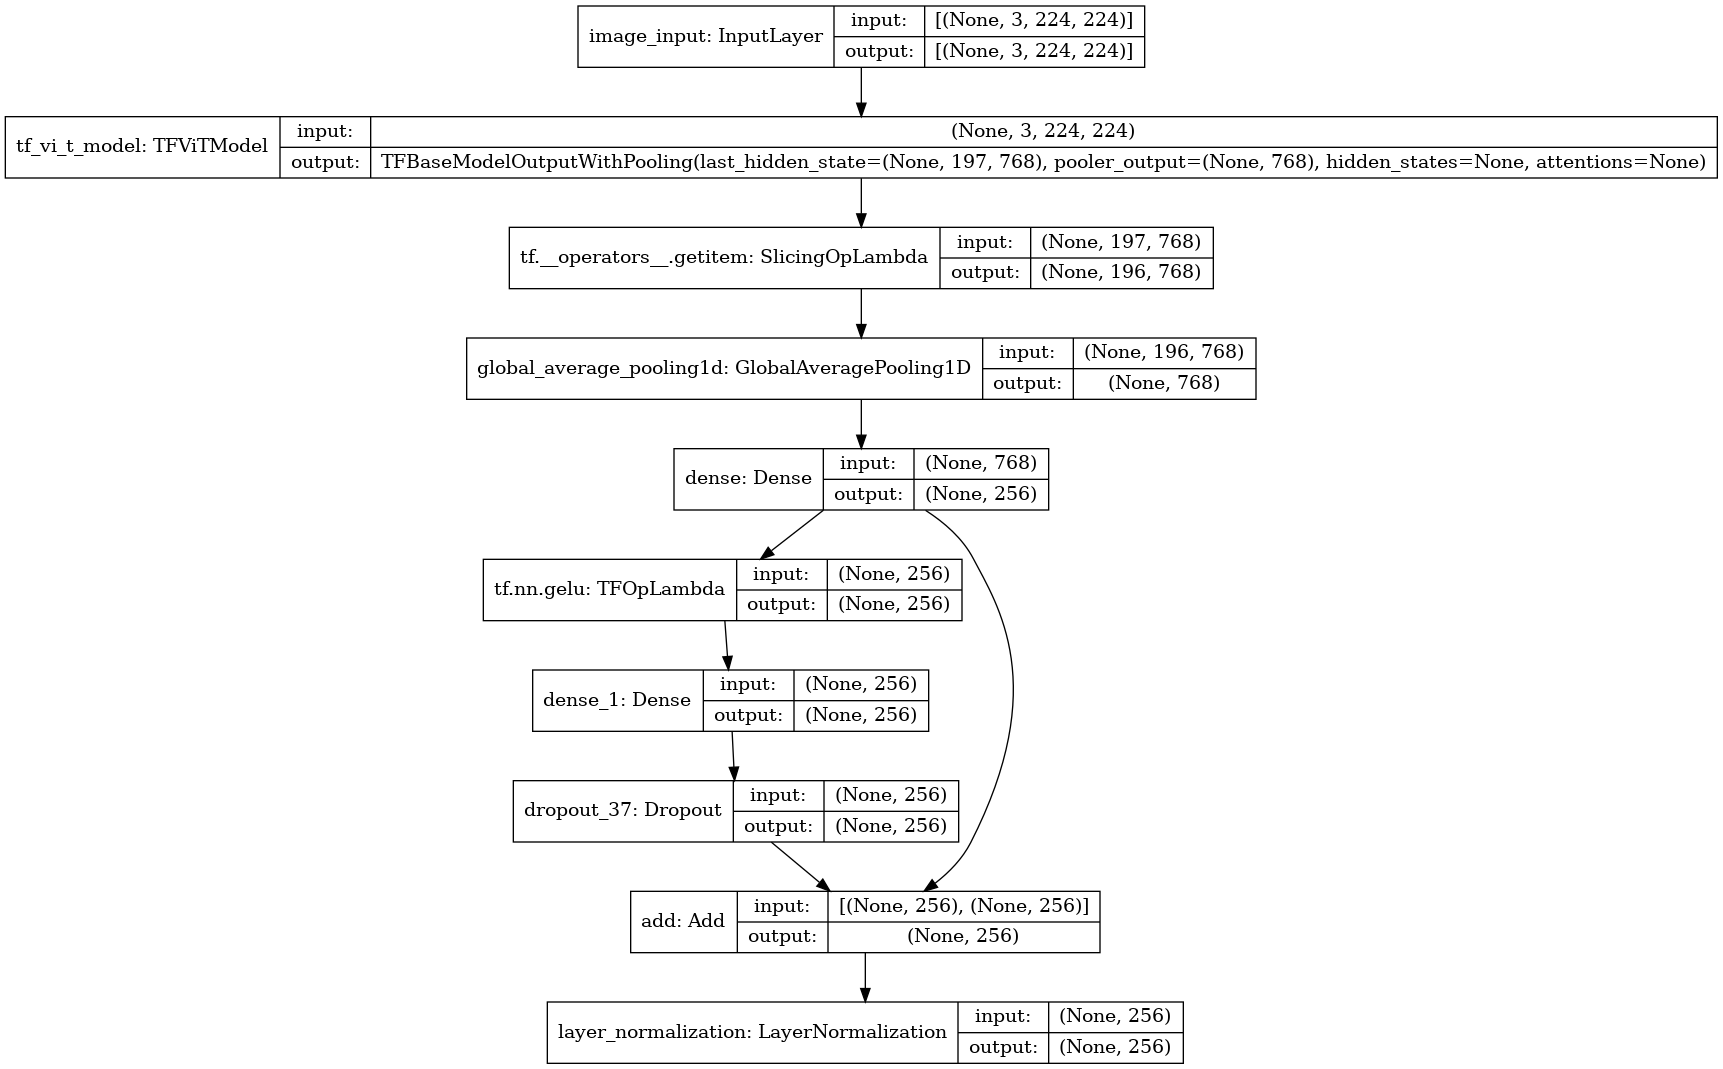

In [15]:
keras.utils.plot_model(vit, show_shapes=True)

In [38]:
vit.summary()

Model: "vision_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
tf_vi_t_model_1 (TFViTModel)    TFBaseModelOutputWit 86389248    image_input[0][0]                
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 196, 768)     0           tf_vi_t_model_1[0][0]            
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf.__operators__.getitem_1[0][0] 
_____________________________________________________________________________________

In [13]:
class MeanPooling(layers.Layer):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def call(self, inputs, masks):
        expanded_masks = tf.broadcast_to(masks[..., None], shape=tf.shape(inputs))
        expanded_masks = tf.cast(expanded_masks, dtype=tf.float32)
        sum_embeddings = tf.reduce_sum(inputs * expanded_masks, axis=1)
        sum_masks = tf.reduce_sum(expanded_masks, axis=1)
        sum_masks = tf.clip_by_value(sum_masks, clip_value_min=1e-9, clip_value_max=tf.reduce_max(sum_masks))
        mean_embeddings = sum_embeddings / sum_masks
        return mean_embeddings

In [14]:
def create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1, trainable=False
):
    base = TFDebertaModel.from_pretrained("kamalkraj/deberta-base")

    for layer in base.layers:
        layer.trainable = False

    input_tokens = layers.Input(shape=(512,), dtype=tf.int32, name="text_input")
    input_masks = layers.Input(shape=(512,), dtype=tf.int32, name="mask_input")
    
    embeddings = base([input_tokens, input_masks]).last_hidden_state
    embeddings = MeanPooling()(embeddings, input_masks)

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    return keras.Model([input_tokens, input_masks], outputs, name="text_encoder")

In [15]:
deberta = create_text_encoder()

Downloading:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at kamalkraj/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


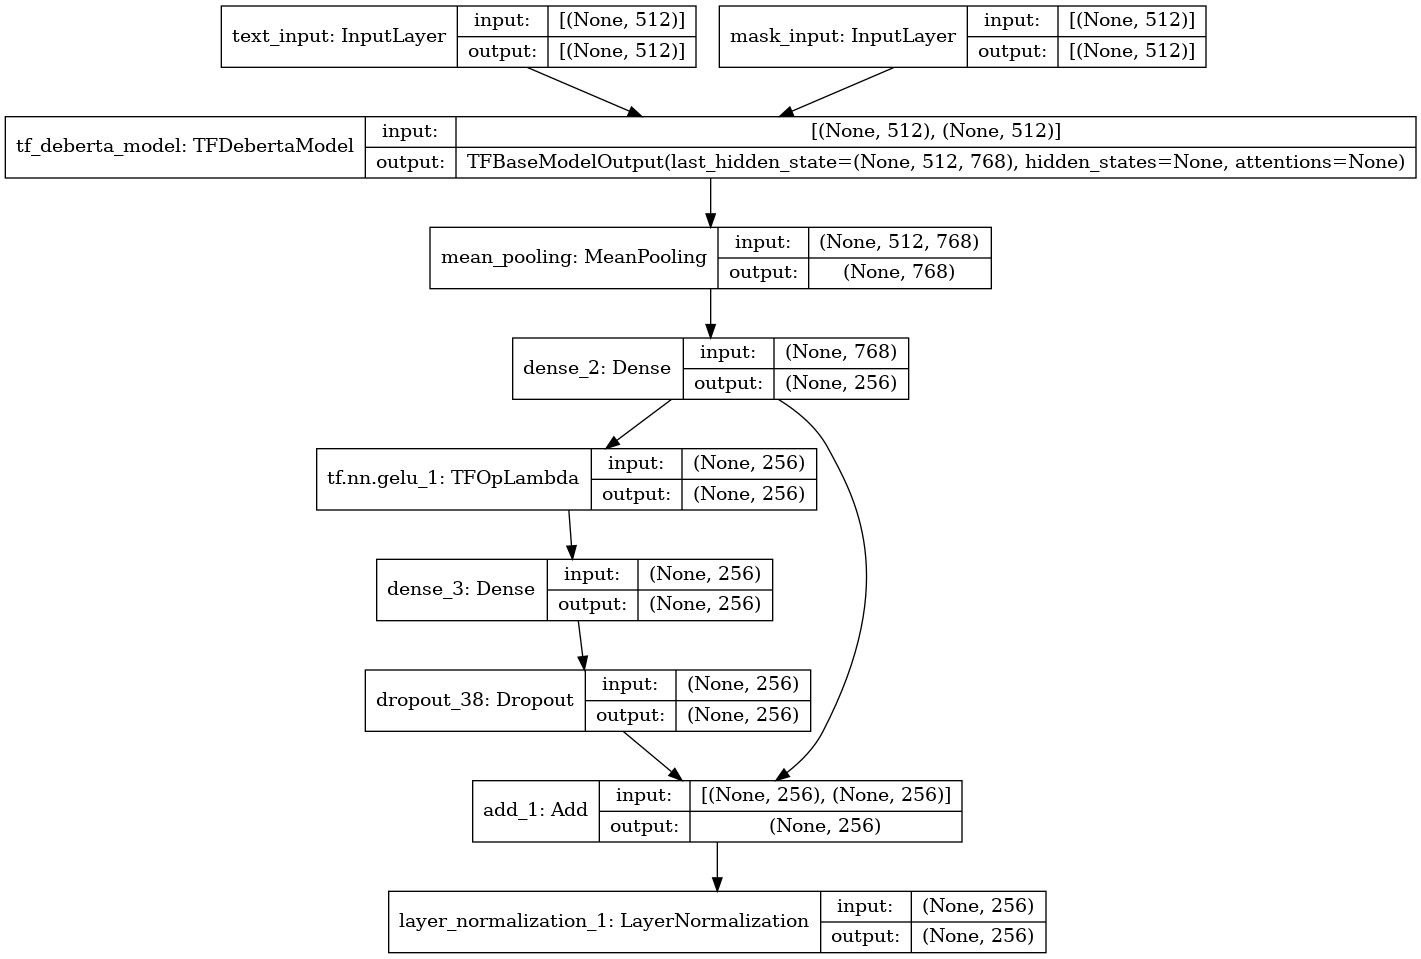

In [20]:
keras.utils.plot_model(deberta, show_shapes=True)

In [21]:
deberta.summary()

Model: "text_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
mask_input (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_deberta_model (TFDebertaMode TFBaseModelOutput(la 138601728   text_input[0][0]                 
                                                                 mask_input[0][0]                 
__________________________________________________________________________________________________
mean_pooling (MeanPooling)      (None, 768)          0           tf_deberta_model[0][0]

In [16]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        images, input_tokens, input_masks = features
        with tf.device("/gpu:0"):
            caption_embeddings = self.text_encoder([input_tokens, input_masks], training=training)
        with tf.device("/gpu:1"):
            image_embeddings = self.image_encoder(images, training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [17]:
model = DualEncoder(deberta, vit)

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)  # high learning rate as backbones are freezed
)

In [ ]:
"""
# Memory exhausted error: too large models. The idea was in pre-training recently initialized layers and then use all acceptable weights

num_epochs = 2

history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=valid_ds,
)
"""
print()

In [19]:
"""
model.image_encoder.trainable = True
model.text_encoder.trainable = True

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.00001, weight_decay=0.00001)  # now all layers are unfreezed, set low learning rate for not corrupt good weights
)
"""
print()

In [ ]:
"""
history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=valid_ds,
)
"""
print()

In [24]:
num_epochs = 4

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=1),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
            ]

history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=valid_ds,
    callbacks=callbacks,
)

Epoch 1/3


2022-11-22 19:58:49.756347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-22 19:59:05.442593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 306 of 320
2022-11-22 19:59:05.857443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1313/1313 [==============================] - 4895s 4s/step - loss: 2.5154 - val_loss: 0.8570
Epoch 2/3


2022-11-22 21:20:27.362024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 304 of 320
2022-11-22 21:20:27.818359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


KeyboardInterrupt: 

In [37]:
def get_test_features():
    for path in test["path"].values.tolist():
        image = Image.open(path)
        image_ids = image_extractor(image)["pixel_values"][0]
        yield image_ids
        
test_ds = tf.data.Dataset.from_generator(get_test_features, output_signature=tf.TensorSpec(shape=(3, 224, 224), dtype=tf.float32) ).batch(batch_size)
image_embeddings = model.image_encoder.predict(test_ds)

In [46]:
def find_matches(image_embeddings, queries, k=12, normalize=True):
    """
    images_ids = []
    for path in image_paths:
        image = Image.open(path)
        image_ids = feature_extractor(image, return_tensors="tf")["pixel_values"]
        images_ids.append(image_ids)
    images_ids = tf.concat(images_ids, axis=0)
    image_embeddings = model.image_encoder.predict(images_ids)
    """
    query = tokenize_text(queries)
    query_ids, query_masks = query["input_ids"], query["attention_mask"]
    query_embedding = model.text_encoder([query_ids, query_masks], training=False)
    
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)

    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    results = tf.math.top_k(dot_similarity, k).indices.numpy()

    return [[test.iloc[idx, 0] for idx in indices] for indices in results]

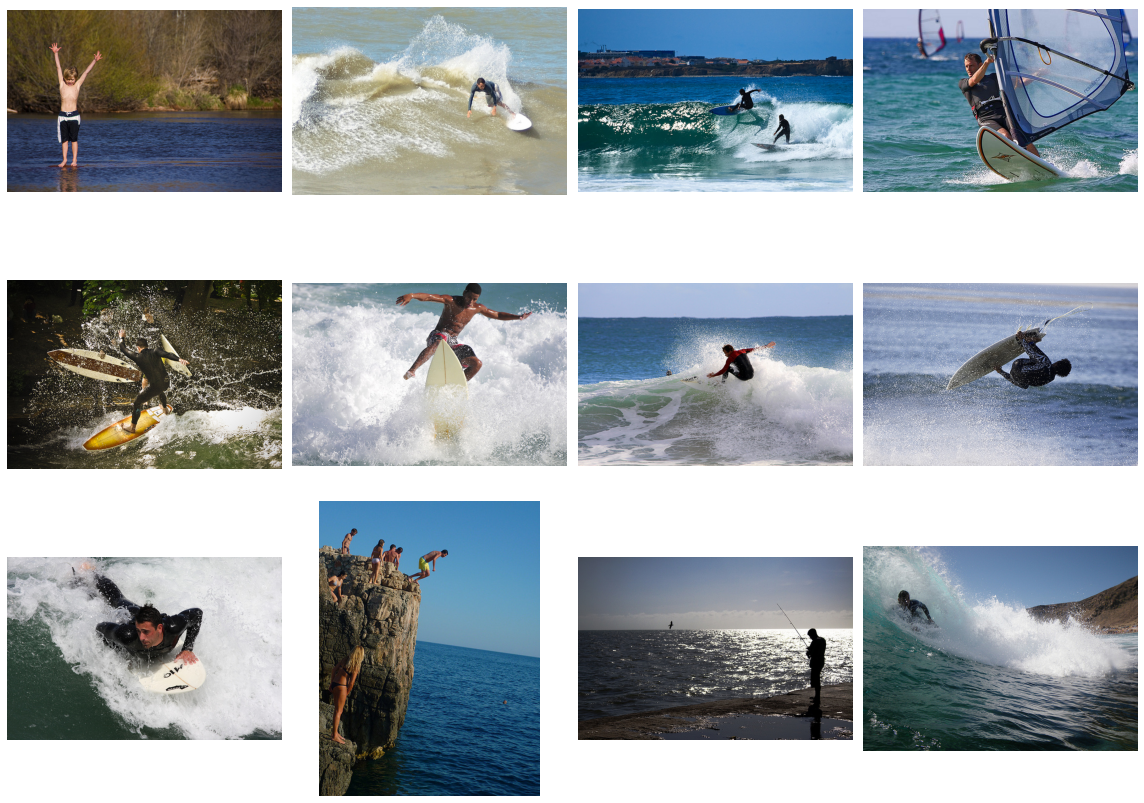

In [50]:
query = "a man is surfing a wave"
matches = find_matches(image_embeddings, query)[0]

rows, cols = len(matches)//4, 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))
ax = ax.flatten()

for i, match in enumerate(matches):
    ax[i].imshow(Image.open(match))
    ax[i].axis("off")
    
plt.tight_layout()
plt.show()

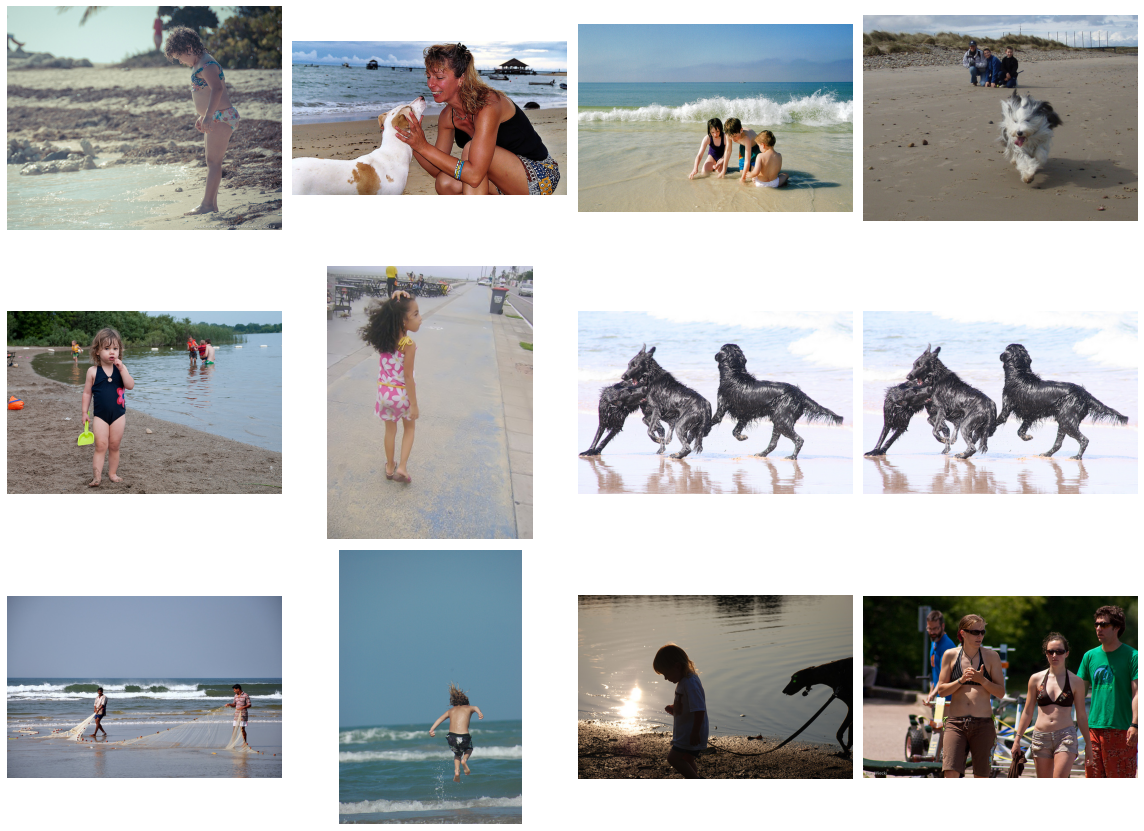

In [49]:
query = "a girl is playing with a dog on the beach"
matches = find_matches(image_embeddings, query)[0]

rows, cols = len(matches)//4, 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))
ax = ax.flatten()

for i, match in enumerate(matches):
    ax[i].imshow(Image.open(match))
    ax[i].axis("off")
    
plt.tight_layout()
plt.show()

In [ ]:
query = "a young couple is doing sports in front of a forest"
matches = find_matches(image_embeddings, query)[0]

rows, cols = len(matches)//4, 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))
ax = ax.flatten()

for i, match in enumerate(matches):
    ax[i].imshow(Image.open(match))
    ax[i].axis("off")
    
plt.tight_layout()
plt.show()

# [View Results](https://www.kaggle.com/code/pankratozzi/tf-text-image-search)

#### Appendix

<code>
""" 
    ViT
    CLS token not added separately 
"""
class Patches(layers.Layer):
    """ Split input image into pathces """
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
 class PatchEncoder(layers.Layer):
    """ Positional encoding """
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    
  def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer encoder block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
    
  </code>
    
   